In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
import re 
import ast
import warnings
warnings.filterwarnings('ignore')

# Compute accuracy

In [7]:
# Define the file path for human ratings dataset
human_ratings_path = "../../data/explica/explica_freq_4800.tsv"

# Load the human ratings dataset into a pandas DataFrame
human_ratings = pd.read_csv(human_ratings_path, sep=",")
# Sort the dataset based on multiple columns to ensure a consistent order
# Sorting by 'pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', and 'tested_order'
# helps in maintaining consistency for further analysis
human_ratings = human_ratings.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order'])

human_ratings.columns

Index(['Sentence_A', 'Sentence_B', 'origin', 'frequency', 'freq_cat',
       'pair_id', 'rating_anticonic_causal', 'rating_iconic_causal',
       'rating_anticonic_temporal', 'rating_iconic_temporal',
       'human_preferred_connective', 'human_preferred_connective_desc',
       'human_preferred_connective_unrel', 'tested_relation', 'tested_order',
       'relation_human', 'order_human', 'condition_human', 'tested_connective',
       'additional_dimension'],
      dtype='object')

In [3]:
import ast
import pandas as pd

def get_model_max_rating_cat(batch_df_sub, desc):
    """
    Determines the connective (word/phrase linking sentences) chosen by humans and models based on different rating criteria.
    
    Parameters:
        batch_df_sub (pd.DataFrame): Subset of the dataset containing sentence pairs and ratings.
        desc (str): Description specifying the evaluation method ('acc' for acceptability, 'mc' for multiple choice, 
                    'perpl' for perplexity, 'cloze' for cloze test).
    
    Returns:
        pd.DataFrame: Updated DataFrame with the human and model-chosen connectives.
    """
    
    # Assign the connective preferred by humans (from precomputed data)
    batch_df_sub['human_chosen_connective'] = batch_df_sub['human_preferred_connective_unrel']

    ##### COMPUTE THE CONNECTIVE CHOSEN BY MODELS
    # Acceptability-Based Selection
    if "acc" in desc:  # Select the connective with the highest rating
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['answer_greedy_cleaned'].transform(
            lambda x: batch_df_sub.loc[x.idxmax(), 'tested_connective']
        )

    # Multiple Choice-Based Selection
    elif "mc" in desc:  # Map the model-generated answer to the corresponding choice in the dictionary
        generated = batch_df_sub["answer_greedy_cleaned"].tolist()
        choices = [eval(x) for x in batch_df_sub["answers_dict"].tolist()]
        chosen_connective = []
        
        for generation, ans_dict in zip(generated, choices):
            if generation not in ans_dict:
                chosen_connective.append("error")  # Handle cases where the model's choice is not found
            else:
                chosen_connective.append(ans_dict[generation])
        
        batch_df_sub["model_chosen_connective"] = chosen_connective

    # Perplexity-Based Selection
    elif "perpl" in desc:  # Select the connective corresponding to the lowest perplexity ranking
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['rank'].transform(
            lambda x: batch_df_sub.loc[x.idxmin(), 'tested_connective']
        )

    # Cloze Test-Based Selection
    elif "cloze" in desc:  # Directly take the model-generated answer
        batch_df_sub['model_chosen_connective'] = batch_df_sub['answer_greedy_cleaned']
    
    # Remove duplicate rows to ensure uniqueness
    batch_df_sub_unique = batch_df_sub.drop_duplicates()
    
    return batch_df_sub_unique


def split_sentence_pairs(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into two DataFrames based on different sentence orders.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing sentence pairs.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames representing different sentence orders.
    """
    
    # Group by sentence pair identifier
    grouped = df.groupby("pair_id")

    df_order_1 = []
    df_order_2 = []

    for _, group in grouped:
        if len(group) == 8:  # Ensuring that each pair appears exactly 8 times (4 per order)
            order_1 = group.iloc[:4]  # First 4 rows for one order
            order_2 = group.iloc[4:]  # Last 4 rows for the reverse order
            df_order_1.append(order_1)
            df_order_2.append(order_2)

    # Concatenating results into two separate DataFrames
    df_order_1 = pd.concat(df_order_1)
    df_order_2 = pd.concat(df_order_2)

    return df_order_1, df_order_2


def clean_compute_max(batch_df, desc):
    """
    Prepares and processes the dataset to determine the most preferred connective for each sentence pair.
    
    Parameters:
        batch_df (pd.DataFrame): The full dataset containing sentence pairs and model predictions.
        desc (str): Description specifying the evaluation method.
    
    Returns:
        pd.DataFrame: Final dataset sorted by pair_id, containing model-selected connectives.
    """

    # Split the dataset into two groups based on different sentence orders
    batch_df_order_1, batch_df_order_2 = split_sentence_pairs(batch_df)
    
    # Compute the preferred connective for each order
    batch_df_BA_unique = get_model_max_rating_cat(batch_df_order_1, desc)
    batch_df_AB_unique = get_model_max_rating_cat(batch_df_order_2, desc)
    
    # Combine the results
    batches = [batch_df_AB_unique, batch_df_BA_unique]
    df = pd.concat(batches)
    
    # Sort results by pair_id for consistency
    df = df.sort_values(['pair_id'])
    
    return df


In [10]:

def compute_accuracy(desc, _dict, accuracies, accur_freq,human_ratings):
    """
    Compute the accuracy of model predictions compared to human ratings.
    
    Parameters:
        desc (str): Description of the evaluation method ('mc' for multiple choice, 'cloze' for cloze test, etc.).
        _dict (dict): Dictionary mapping model names to file paths.
        accuracies (dict): Dictionary to store computed accuracy values.
        human_ratings (pd.DataFrame): DataFrame containing human ratings.
    
    Returns:
        dict: Updated accuracies dictionary with computed accuracy values.
    """
    print("*** Task:", desc)
    for model, path in _dict.items():
        print("***** Model:", model)
        
        df_curr = pd.read_csv(path, sep="\t")
        
        # Prepare a dictionary to store accuracies for the current model
        key = desc + "_" + model
        accuracies[key] = dict()
        accur_freq[key] = dict()
        
        # Standardize the dataset format
        if "mc" in desc:  # Multiple-choice format has a different order representation
            order_map = {'<A;B>': "B follows A", '<B;A>': "A follows B", 'none': 'none'}
            df_curr['order'] = df_curr['order'].map(order_map)
            
        # Drop eventual duplicates for multiple-choice and cloze    
        if "mc" in desc or "cloze" in desc:
            df_curr = df_curr.drop_duplicates(subset=["Sentence_A", "Sentence_B"], keep="first")
            
            
        # Sort data and standardize column names for consistency
        if "relation" in df_curr and "order" in df_curr and "conn_in_list" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'relation', 'order', 'conn_in_list']) 
            df_curr["tested_relation"] = df_curr["relation"]
            del df_curr["relation"]
            df_curr["tested_order"] = df_curr["order"]
            del df_curr["order"]
            df_curr["tested_connective"] = df_curr["conn_in_list"]
            del df_curr["conn_in_list"]
        elif "tested_relation" in df_curr and "tested_order" in df_curr and "tested_connective" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']) 
        else:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B'])
     
        
        
        # Merge with human ratings based on evaluation type
        if "mc" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned', 'answers_dict']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        elif "cloze" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        else:
            df_curr_with_human = pd.merge(
                df_curr, 
                human_ratings[['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective', 'order_human', 'relation_human', 'condition_human', 'human_preferred_connective_unrel', 'freq_cat']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']
            )
            
        # Compute accuracy
        df_human_gt = clean_compute_max(df_curr_with_human, desc)
        
        # Filter dataset into different categories based on order and relation
        df_human_gt_caus_AB = df_human_gt[(df_human_gt['order_human'] == "A,B") & (df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_AB = df_human_gt[(df_human_gt['order_human'] == "A,B") & (df_human_gt['relation_human'] == "Temporal")]
        df_human_gt_caus_BA = df_human_gt[(df_human_gt['order_human'] == "B,A") & (df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_BA = df_human_gt[(df_human_gt['order_human'] == "B,A") & (df_human_gt['relation_human'] == "Temporal")]
        
        # Compute overall accuracy
        total = pd.concat([df_human_gt_caus_AB, df_human_gt_temp_AB, df_human_gt_caus_BA, df_human_gt_temp_BA])
        correct = total[total['human_preferred_connective_unrel'] == total["model_chosen_connective"]].shape[0]
        accuracy_total = correct / total.shape[0]
        accuracies[key]["Overall"] = accuracy_total
        accur_freq[key]["Overall"] = accuracy_total
        
        # Compute accuracy per category
        dfs = {
        "Caus. Icon" : df_human_gt_caus_AB,
        "Temp. Icon" : df_human_gt_temp_AB,
        "Caus. a.Icon" : df_human_gt_caus_BA,
        "Temp. a.Icon" : df_human_gt_temp_BA,
       
        }

        for k, v in dfs.items():
            correct = v[(v['human_chosen_connective'] == v["model_chosen_connective"])].shape[0]
            accuracy = correct/v.shape[0]
            accuracies[key][k] =  accuracy
            
        ########## Compute accuracy per frequency category
        
        # Get unique values in freq_cat
        freq_categories = total["freq_cat"].unique()

        # Create a dictionary to store sub-dataframes
        sub_dfs = {}
 
            
        for freq in freq_categories:
            freq_key = f"{freq.lower()}"
            sub_dfs[freq_key] = total[total['freq_cat'] == freq]
            
        freq_dfs = {
            "Rare": sub_dfs['1_rare'],
            "Uncommon": sub_dfs['2_uncommon'],
            "Common": sub_dfs['3_common'],
            "Frequent": sub_dfs['4_frequent'],
        }


        for k, v in freq_dfs.items():
            correct = v[(v['human_preferred_connective_unrel'] == v["model_chosen_connective"])].shape[0]
            accuracy = correct/v.shape[0]
            accur_freq[key][k] =  accuracy
    return accuracies, accur_freq

In [11]:
accuracies = dict()
accur_freq = dict()

acc_qwen_dict = {"qwen0.5" : "../../data/res/acceptability/fewshot/accept_res_outlines_Qwen2.5-0.5B-Instruct_cleaned.tsv",
"qwen7" : "../../data/res/acceptability/fewshot/accept_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv",
"qwen1.5" : "../../data/res/acceptability/fewshot/accept_res_outlines_Qwen2.5-1.5B-Instruct_cleaned.tsv",
"qwen3" : "../../data/res/acceptability/fewshot/accept_res_outlines_Qwen2.5-3B-Instruct_cleaned.tsv",
"qwen14": "../../data/res/acceptability/fewshot/accept_few_Qwen2.5-14B-Instruct_cleaned.tsv",
"qwen32": "../../data/res/acceptability/fewshot/accept_few_Qwen2.5-32B-Instruct_cleaned.tsv"}


accuracies, accur_freq = compute_accuracy("acc_qwen_dict", acc_qwen_dict, accuracies, accur_freq, human_ratings)


###########*******

perpl_dict = {
    "qwen0.5": "../../data/res/perplexity/Qwen2.5-0.5B-Instruct.csv",
    "qwen7": "../../data/res/perplexity/Qwen2.5-7B-Instruct.csv",
    "qwen1.5": "../../data/res/perplexity/Qwen2.5-1.5B-Instruct.csv",
    "qwen3": "../../data/res/perplexity/Qwen2.5-3B-Instruct.csv",
    "qwen14": "../../data/res/perplexity/perplexity_Qwen2.5-14B-Instruct.tsv",
    "qwen32":"../../data/res/perplexity/perplexity_Qwen2.5-32B-Instruct.tsv"
}



accuracies, accur_freq = compute_accuracy("perpl", perpl_dict, accuracies, accur_freq, human_ratings)









*** Task: acc_qwen_dict
***** Model: qwen0.5
***** Model: qwen7
***** Model: qwen1.5
***** Model: qwen3
***** Model: qwen14
***** Model: qwen32
*** Task: perpl
***** Model: qwen0.5
***** Model: qwen7
***** Model: qwen1.5
***** Model: qwen3
***** Model: qwen14
***** Model: qwen32


In [12]:
accuracies

{'acc_qwen_dict_qwen0.5': {'Overall': 0.2688679245283019,
  'Caus. Icon': 0.1073170731707317,
  'Temp. Icon': 0.026923076923076925,
  'Caus. a.Icon': 0.4885844748858447,
  'Temp. a.Icon': 0.5609756097560976},
 'acc_qwen_dict_qwen7': {'Overall': 0.47641509433962265,
  'Caus. Icon': 0.4975609756097561,
  'Temp. Icon': 0.36153846153846153,
  'Caus. a.Icon': 0.5570776255707762,
  'Temp. a.Icon': 0.524390243902439},
 'acc_qwen_dict_qwen1.5': {'Overall': 0.2971698113207547,
  'Caus. Icon': 0.6097560975609756,
  'Temp. Icon': 0.11153846153846154,
  'Caus. a.Icon': 0.2922374429223744,
  'Temp. a.Icon': 0.2073170731707317},
 'acc_qwen_dict_qwen3': {'Overall': 0.35495283018867924,
  'Caus. Icon': 0.7219512195121951,
  'Temp. Icon': 0.28076923076923077,
  'Caus. a.Icon': 0.1141552511415525,
  'Temp. a.Icon': 0.3353658536585366},
 'acc_qwen_dict_qwen14': {'Overall': 0.5990566037735849,
  'Caus. Icon': 0.8048780487804879,
  'Temp. Icon': 0.7153846153846154,
  'Caus. a.Icon': 0.5114155251141552,
  '

# Plot accuracy for incremental size models by category

In [13]:
df_2 = pd.DataFrame(accuracies).T

In [14]:
df_2

,Overall,Caus. Icon,Temp. Icon,Caus. a.Icon,Temp. a.Icon
acc_qwen_dict_qwen0.5,0.268868,0.107317,0.026923,0.488584,0.560976
acc_qwen_dict_qwen7,0.476415,0.497561,0.361538,0.557078,0.524390
acc_qwen_dict_qwen1.5,0.297170,0.609756,0.111538,0.292237,0.207317
acc_qwen_dict_qwen3,0.354953,0.721951,0.280769,0.114155,0.335366
acc_qwen_dict_qwen14,0.599057,0.804878,0.715385,0.511416,0.274390
acc_qwen_dict_qwen32,0.682783,0.873171,0.526923,0.826484,0.500000
perpl_qwen0.5,0.458726,0.868293,0.434615,0.424658,0.030488
perpl_qwen7,0.593160,0.829268,0.526923,0.652968,0.323171
perpl_qwen1.5,0.469340,0.941463,0.403846,0.442922,0.018293
perpl_qwen3,0.535377,0.848780,0.538462,0.598174,0.054878


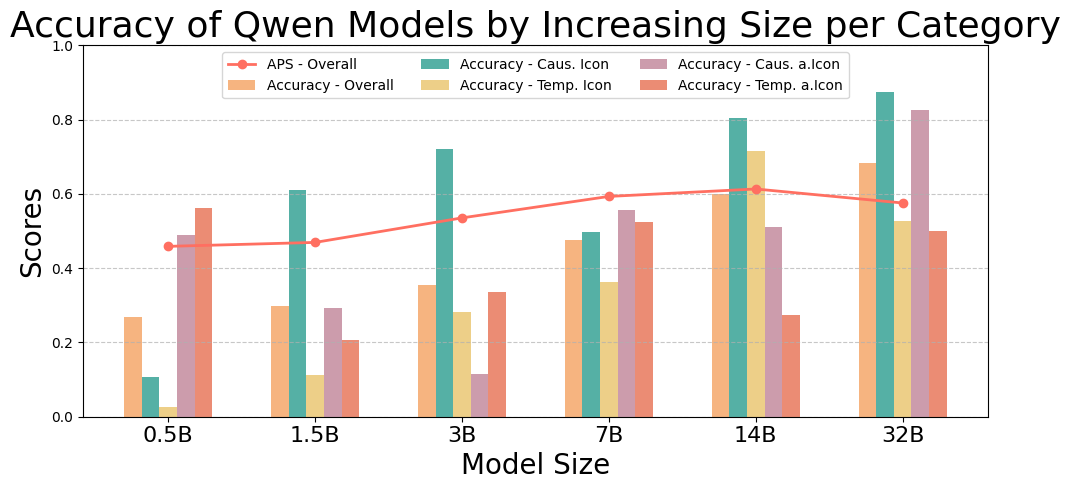

In [15]:

# Dictionary containing accuracy and perplexity results
data = accuracies  

# Model size parameters (Qwen models with different parameter counts)
models = ['0.5B', '1.5B', '3B', '7B', '14B', '32B']

# Keys to access accuracy data in the dictionary
acc_keys = [f'acc_qwen_dict_qwen{model}' for model in ['0.5', '1.5', '3', '7', '14', '32']]

# Keys to access perplexity data in the dictionary
perpl_keys = [f'perpl_qwen{model}' for model in ['0.5', '1.5', '3', '7', '14', '32']]

# Categories of accuracy being analyzed
categories = ['Overall', 'Caus. Icon', 'Temp. Icon', 'Caus. a.Icon', 'Temp. a.Icon', ]

# Extract accuracy data for each category across all model sizes
acc_data = [[data[key][category] for key in acc_keys] for category in categories]

# Extract overall perplexity scores for each model
perpl_overall = [data[key]['Overall'] for key in perpl_keys]

# Define x-axis positions for categorical values (model sizes)
x = np.arange(len(models))
width = 0.12  # Adjusted bar width for better spacing between categories

# Define a soft color palette (avoiding blue for better contrast)
colors = ['#F4A261', '#2A9D8F', '#E9C46A', '#C08497', '#E76F51']  # Light warm color scheme
line_color = '#FF6F61'  # Light coral color for the perplexity line

# Create the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Number of accuracy categories
num_categories = len(categories)

# Plot bar graphs for each accuracy category
for i, (cat_data, category) in enumerate(zip(acc_data, categories)):
    ax.bar(
        x + i * width - (width * (num_categories - 1) / 2),  # Offset each category slightly to avoid overlap
        cat_data, 
        width, 
        label=f'Accuracy - {category}', 
        color=colors[i], 
        alpha=0.8  # Slight transparency for better visualization
    )

# Plot perplexity scores as a line graph overlaying the bars
ax.plot(
    x, 
    perpl_overall, 
    marker='o', 
    color=line_color, 
    linewidth=2, 
    label='APS - Overall'
)

# Format x-axis with categorical labels (model sizes)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=16)

# Set y-axis range from 0 to 1 (since accuracy values range within this limit)
ax.set_ylim(0, 1)

# Add a horizontal grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add axis labels and title with appropriate font sizes
ax.set_xlabel("Model Size", fontsize=20)
ax.set_ylabel("Scores", fontsize=20)
ax.set_title("Accuracy of Qwen Models by Increasing Size per Category", fontsize=26)

# Add legend for clarity, adjusting font size and position
ax.legend(fontsize=10, loc='upper center', ncol=3)

# Adjust layout to fit all elements properly
plt.tight_layout()

# Display the plot
plt.show()


# Plot accuracy for incremental size models overall

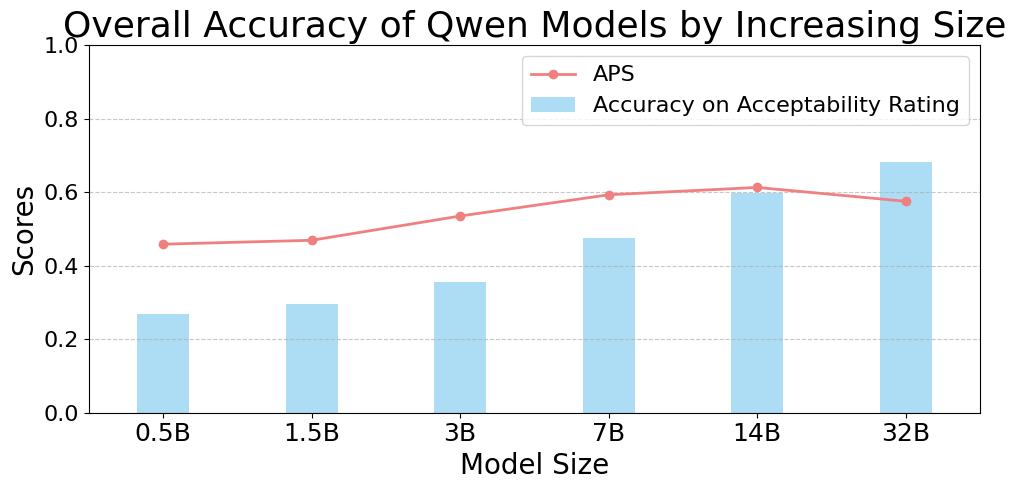

In [16]:


# Dictionary containing accuracy and perplexity results
data = accuracies  

# Model size parameters (Qwen models with different parameter counts)
models = ['0.5B', '1.5B', '3B', '7B', '14B', '32B']

# Keys to access accuracy data in the dictionary
acc_keys = [f'acc_qwen_dict_qwen{model}' for model in ['0.5', '1.5', '3', '7', '14', '32']]

# Keys to access perplexity data in the dictionary
perpl_keys = [f'perpl_qwen{model}' for model in ['0.5', '1.5', '3', '7', '14', '32']]

# Category of interest (Overall accuracy)
category = 'Overall'

# Extract accuracy data for the "Overall" category across all model sizes
acc_data = [data[key][category] for key in acc_keys]

# Extract overall perplexity scores for each model
perpl_overall = [data[key]['Overall'] for key in perpl_keys]

# Define x-axis positions for categorical values (model sizes)
x = np.arange(len(models))
width = 0.35  # Width of the bars in the bar chart

# Create figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot for "Overall" accuracy (using Light Blue color)
ax.bar(
    x, 
    acc_data, 
    width, 
    color='#89CFF0',  # Light Blue
    alpha=0.7,  # Slight transparency for better readability
    label='Accuracy on Acceptability Rating'  # Legend label
)

# Line plot for "Overall" perplexity (overlaying the bars, using Light Coral)
ax.plot(
    x, 
    perpl_overall, 
    marker='o',  # Circular markers for each point
    color='#F08080',  # Light Coral
    linewidth=2, 
    label='APS'  # Legend label
)

# Format x-axis with categorical labels (model sizes)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=18)  # Increase x-tick label font size by 20%

# Adjust x-axis limits to ensure full visibility of all bars and markers
ax.set_xlim(-0.5, len(models) - 0.5)

# Optional: Set y-axis range from 0 to 1 (since accuracy values usually range within this limit)
ax.set_ylim(0, 1)

# Add horizontal grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Dashed grid lines on the y-axis

# Configure axis labels and title with larger font sizes for better visibility
ax.set_xlabel("Model Size", fontsize=20)
ax.set_ylabel("Scores", fontsize=20)
ax.set_title("Overall Accuracy of Qwen Models by Increasing Size", fontsize=26)

# Add a legend to describe the plotted elements
ax.legend(fontsize=16)  # Increase legend font size

# Increase y-axis tick label size for better readability
ax.tick_params(axis='y', labelsize=16)

# Adjust layout to ensure all elements fit properly
plt.tight_layout()

# Display the plot
plt.show()


# Plot accuracy for incremental size models by freq category

In [17]:
df_2_freq = pd.DataFrame(accur_freq).T

In [18]:
df_2_freq

,Overall,Rare,Uncommon,Common,Frequent
acc_qwen_dict_qwen0.5,0.268868,0.275058,0.233020,0.273504,0.302111
acc_qwen_dict_qwen7,0.476415,0.493007,0.489028,0.484737,0.432718
acc_qwen_dict_qwen1.5,0.297170,0.341492,0.294671,0.264957,0.284960
acc_qwen_dict_qwen3,0.354953,0.342657,0.367816,0.361416,0.345646
acc_qwen_dict_qwen14,0.599057,0.600233,0.592476,0.600733,0.604222
acc_qwen_dict_qwen32,0.682783,0.658508,0.695925,0.694750,0.680739
perpl_qwen0.5,0.458726,0.469697,0.459770,0.461538,0.441953
perpl_qwen7,0.593160,0.553613,0.665622,0.578755,0.562005
perpl_qwen1.5,0.469340,0.497669,0.518286,0.416361,0.432718
perpl_qwen3,0.535377,0.513986,0.556949,0.540904,0.526385


In [19]:
palette = [
     # Reds 
    '#faa0a0',  # Light salmon red
    '#fac4a4',  # Pastel orange
    '#f17c54',  # Light orange-red
    '#d62728',  # Original red
    '#c0392b',  # Original strong red
    '#8a2620',  # Darker red

 # Greens 
    '#caffd5',  # Pastel yellow-green
    '#9df2a3',  # Soft green-yellow
    '#6ae07a',  # Yellow-green
    '#4caf50',  # Original medium green
    '#3b8f44',  # Forest green
    '#1d8348',  # Original dark forest green
]

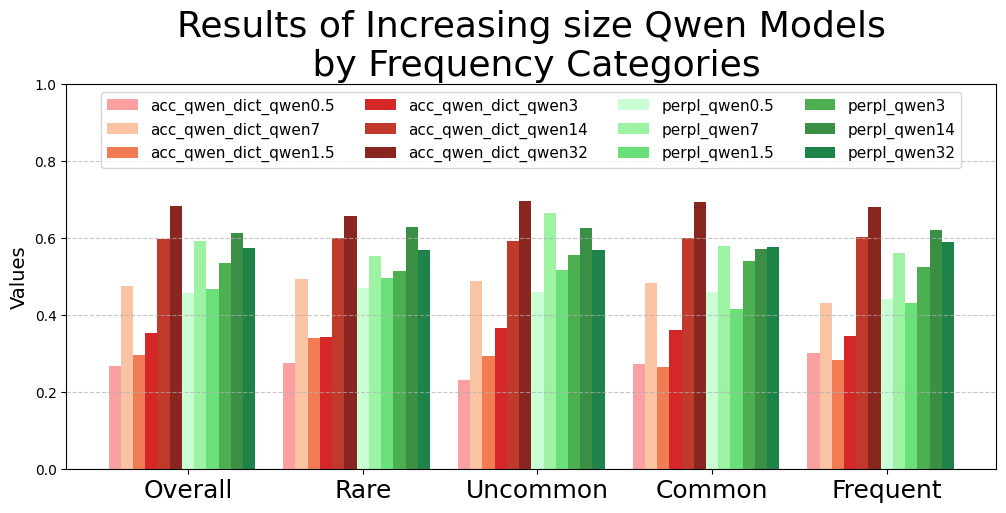

In [22]:

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 0.07
x_labels = df_2_freq.columns
x = np.arange(len(x_labels))

for i, index_label in enumerate(df_2_freq.index):
    plt.bar(x + i * bar_width, df_2_freq.loc[index_label], width=bar_width, label=index_label, color= palette[i])
    
# Optional: Set y-axis from 0 to 1 (if needed)
ax.set_ylim(0, 1)

# Add horizontal grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Dashed grid lines on y-axis

plt.ylabel("Values", fontsize = 14)
plt.title("Results of Increasing size Qwen Models\n by Frequency Categories", fontsize=26)
plt.xticks(x + bar_width * (len(df_2.index) / 2), x_labels,fontsize = 18)
plt.legend(loc="upper center", ncols = 4, fontsize=11)
plt.show()